# Lab-14. Clustering 2.

Objectives:

- When K-means is not a good choice
- AgglomerativeClustering (Dendograms, Hierarchical Clustering)
- DBSCAN
  
Self-practice: A small task to see how clustering can be used for image segmentation.


## When Kmeans is inefficient (from previous lab)

> task: Apply Kmean on the following datasets and interpret the results. First, complete the function `k_means_and_plot` to fit Kmeans and to visualize the results. Then, conclude on why Kmean is does work well on these datasets

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.spatial.distance import cdist
from copy import deepcopy
from mlxtend.plotting import plot_decision_regions

from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt


In [2]:
class KMeans(BaseEstimator, ClassifierMixin):

    def __init__(self, k=3, centers=None):
        self.k = k
        self.centers = centers

    def _predict(self, X, centers):
        distance = cdist(X, centers)
        return np.argmin(distance, axis=1)

    def predict(self, X, y=None):
        return self._predict(X, self.centers)

    def fit(self, X, y=None):
        k = self.k
        c = X.shape[1]
        if self.centers is None:
            mean = np.mean(X, axis = 0)
            std = np.std(X, axis = 0)
            self.centers = np.random.randn(k, c) * std + mean
        centers = self.centers
        centers_new = deepcopy(self.centers) # Store new centers

        error = -1

        # When, after an update, the estimate of that center stays the same, exit loop
        while error != 0:
            clusters = self._predict(X, centers)
            centers_old = deepcopy(centers_new)
            for i in range(k):
                centers_new[i] = np.mean(X[clusters == i], axis=0)
                

            error = np.linalg.norm(centers_new - centers_old)
            centers = centers_new
        self.centers = centers_new
        return self

    def score(self, X, y=None):
        return 0


In [3]:
from numpy.random import choice

def choose(X, prob):
    idx = choice(X.shape[0], 1, p=prob)
    return X[idx]     

def kmeans_pp(X, k):
    n = X.shape[0]
    weights = np.ones(n) / n
    centers = []
    while len(centers) < k:
        # Choose a centroid with the current weights
        centroid = choose(X, weights)
        centers.extend(centroid)

        # Calculate the pair-wise distances
        # between the datapoints X and the current centers
        # get min distance then square it.
        # Obtain new probabilities in weights.
        distances = cdist(X, centers)
        min_dist = distances.min(axis=1)
        d_squared = min_dist**2
        weights = d_squared / d_squared.sum()

    return np.array(centers)

In [4]:
def k_means_and_plot(X, y, k=2):
    initial_centers = kmeans_pp(X, k)
    clf = KMeans(k, initial_centers).fit(X,y)
    y_pred = clf.predict(X)
    plot_decision_regions(X=X, y=y_pred, clf=clf, legend=2)
    plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250,label='Centroids')
    plt.legend()

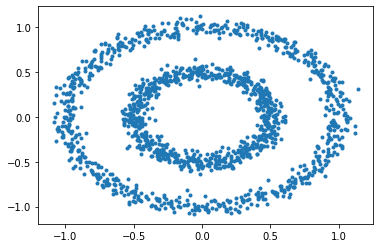

In [5]:
from sklearn.datasets import make_circles 
n_samples = 1500
X, y = make_circles(n_samples=n_samples, factor=.5, noise=.05)
plt.scatter(X[:,0], X[:,1], marker='.')

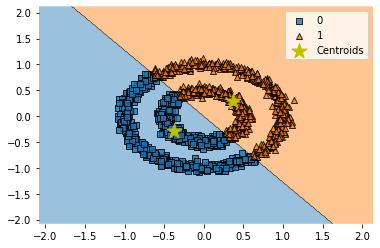

In [6]:
k_means_and_plot(X=X, y=y)

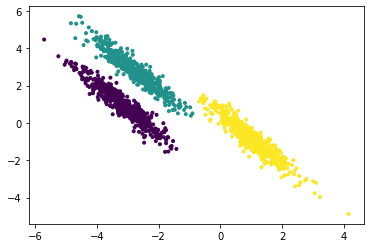

In [7]:
# Anisotropicly distributed data
random_state = 170
X, y_aniso = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y_aniso)
plt.scatter(X_aniso[:,0], X_aniso[:,1], marker='.', c=y_aniso) 

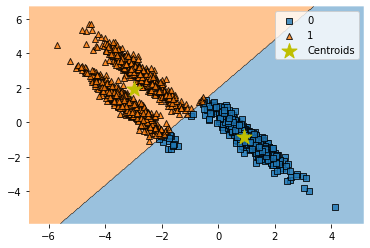

In [8]:
k_means_and_plot(X_aniso, y_aniso)

### AgglomerativeClustering

## Case

Imagine a scenario in which you are part of a data science team that interfaces with the marketing department. Marketing has been gathering customer shopping data for a while, and they want to understand, based on the collected data, if there are similarities between customers. Those similarities divide customers into groups and having customer groups helps in the targeting of campaigns, promotions, conversions, and building better customer relationships.

In this case, our marketing data is fairly small. We have information on only 200 customers. Considering the marketing team, it is important that we can clearly explain to them how the decisions were made based on the number of clusters, therefore explaining to them how the algorithm actually works.

Since our data is small and explicability is a major factor, we can leverage Hierarchical Clustering to solve this problem. This process is also known as Hierarchical Clustering Analysis (HCA).

> One of the advantages of HCA is that it is interpretable and works well on small datasets.


### Data analysis

In [9]:
import pandas as pd

dataset_name = 'hierarchical-clustering-with-python-and-scikit-learn-shopping-data.csv'

customer_data = pd.read_csv(dataset_name)

In [10]:
customer_data.shape

(200, 5)

In [11]:
customer_data.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

Here, we see that marketing has generated a CustomerID, gathered the Genre, Age, Annual Income (in thousands of dollars), and a Spending Score going from 1 to 100 for each of the 200 customers. When asked for clarification, they said that the values in the Spending Score column signify how often a person spends money in a mall on a scale of 1 to 100. In other words, if a customer has a score of 0, this person never spends money, and if the score is 100, we have just spotted the highest spender.


<AxesSubplot:>

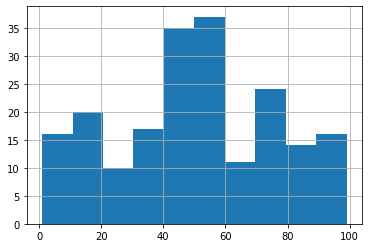

In [12]:
customer_data['Spending Score (1-100)'].hist()

In [13]:
customer_data['Genre'].unique()

array(['Male', 'Female'], dtype=object)

In [14]:
customer_data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Encoding Variables and Feature Engineering

Let's start by dividing the Age into groups that vary in 10, so that we have 20-30, 30-40, 40-50, and so on. Since our youngest customer is 15, we can start at 15 and end at 70, which is the age of the oldest customer in the data. Starting at 15, and ending at 70, we would have 15-20, 20-30, 30-40, 40-50, 50-60, and 60-70 intervals.

To group or bin Age values into these intervals, we can use the Pandas cut() method to cut them into bins and then assign the bins to a new Age Groups column:

In [15]:
intervals = [15, 20, 30, 40, 50, 60, 70]
col = customer_data['Age']
customer_data['Age Groups'] = pd.cut(x=col, bins=intervals)

# To be able to look at the result stored in the variable
customer_data['Age Groups']

0      (15, 20]
1      (20, 30]
2      (15, 20]
3      (20, 30]
4      (30, 40]
         ...   
195    (30, 40]
196    (40, 50]
197    (30, 40]
198    (30, 40]
199    (20, 30]
Name: Age Groups, Length: 200, dtype: category
Categories (6, interval[int64, right]): [(15, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70]]

In [16]:
customer_data.groupby('Age Groups')['Age Groups'].count()

Age Groups
(15, 20]    17
(20, 30]    45
(30, 40]    60
(40, 50]    38
(50, 60]    23
(60, 70]    17
Name: Age Groups, dtype: int64

It is easy to spot that most customers are between 30 and 40 years of age, followed by customers between 20 and 30 and then customers between 40 and 50. This is also good information for the Marketing department.

At the moment, we have two categorical variables, Age and Genre, which we need to transform into numbers to be able to use in our model. There are many different ways of making that transformation - we will use the Pandas get_dummies() method that creates a new column for each interval and genre and then fill its values with 0s and 1s- this kind of operation is called one-hot encoding. Let's see how it looks:

In [17]:
# The _oh means one-hot
customer_data_oh = pd.get_dummies(customer_data)
# Display the one-hot encoded dataframe
customer_data_oh

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Genre_Female,Genre_Male,"Age Groups_(15, 20]","Age Groups_(20, 30]","Age Groups_(30, 40]","Age Groups_(40, 50]","Age Groups_(50, 60]","Age Groups_(60, 70]"
0,1,19,15,39,0,1,1,0,0,0,0,0
1,2,21,15,81,0,1,0,1,0,0,0,0
2,3,20,16,6,1,0,1,0,0,0,0,0
3,4,23,16,77,1,0,0,1,0,0,0,0
4,5,31,17,40,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,35,120,79,1,0,0,0,1,0,0,0
196,197,45,126,28,1,0,0,0,0,1,0,0
197,198,32,126,74,0,1,0,0,1,0,0,0
198,199,32,137,18,0,1,0,0,1,0,0,0


### Plotting Each Pair of Data

Since plotting 10 dimensions is a bit impossible, we'll plot the combination of the initial features. We can choose two of them for our clustering analysis. One way we can see all of our data pairs combined is with a Seaborn pairplot():

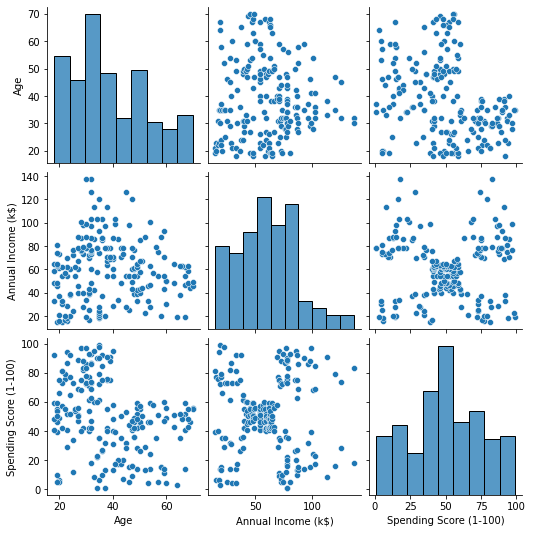

In [10]:
import seaborn as sns

# Dropping CustomerID column from data 
customer_data = customer_data.drop('CustomerID', axis=1)

# plot the pair plot that shows the relationship between the features
# 1 line

sns.pairplot(customer_data)

At a glance, we can spot the scatterplots that seem to have groups of data. One that seems interesting is the scatterplot that combines Annual Income and Spending Score. Notice that there is no clear separation between other variable scatterplots. At the most, we can maybe tell that there are two distinct concentrations of points in the Spending Score vs Age scatterplot.

Both scatterplots consisting of Annual Income and Spending Score are essentially the same. We can see it twice because the x and y-axis were exchanged. By taking a look at any of them, we can see what appears to be five different groups. Let's plot just those two features with a Seaborn scatterplot() to take a closer look:

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

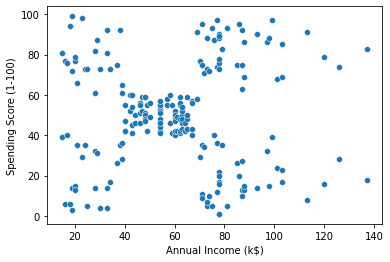

In [11]:
sns.scatterplot(x=customer_data['Annual Income (k$)'],
                y=customer_data['Spending Score (1-100)'])

We will be using theese two features for our clustering analysis.

### Visualizing Hierarchical Structure with Dendrograms

So far, we have explored the data, one-hot encoded categorical columns, decided which columns were fit for clustering. The plots indicate we have 5 clusters in our data, but there's also another way to visualize the relationships between our points and help determine the number of clusters - by creating a dendrogram (commonly misspelled as dendogram). Dendro means tree in Latin.

The dendrogram is a result of the linking of points in a dataset. It is a visual representation of the hierarchical clustering process. And how does the hierarchical clustering process work? Well... it depends - probably an answer you've already heard a lot in Data Science.

### Understanding Hierarchical Clustering
When the Hierarchical Clustering Algorithm (HCA) starts to link the points and find clusters, it can first split points into 2 large groups, and then split each of those two groups into smaller 2 groups, having 4 groups in total, which is the divisive and top-down approach.

Alternatively, it can do the opposite - it can look at all the data points, find 2 points that are closer to each other, link them, and then find other points that are the closest ones to those linked points and keep building the 2 groups from the bottom-up. Which is the agglomerative approach we will develop.

#### Steps to Perform Agglomerative Hierarchical Clustering

To make the agglomerative approach even clear, there are steps of the Agglomerative Hierarchical Clustering (AHC) algorithm:

1. At the start, treat each data point as one cluster. Therefore, the number of clusters at the start will be K - while K is an integer representing the number of data points.

2. Form a cluster by joining the two closest data points resulting in K-1 clusters.

3. Form more clusters by joining the two closest clusters resulting in K-2 clusters.

4. Repeat the above three steps until one big cluster is formed.

> If you invert the steps of the ACH algorithm, going from 4 to 1 - those would be the steps to *Divisive Hierarchical Clustering (DHC)*.


Notice that HCAs can be either divisive and top-down, or agglomerative and bottom-up. The top-down DHC approach works best when you have fewer, but larger clusters, hence it's more computationally expensive. On the other hand, the bottom-up AHC approach is fitted for when you have many smaller clusters. It is computationally simpler, more used, and more available.

Let's plot our customer data dendrogram to visualize the hierarchical relationships of the data. This time, we will use the scipy library to create the dendrogram for our dataset:

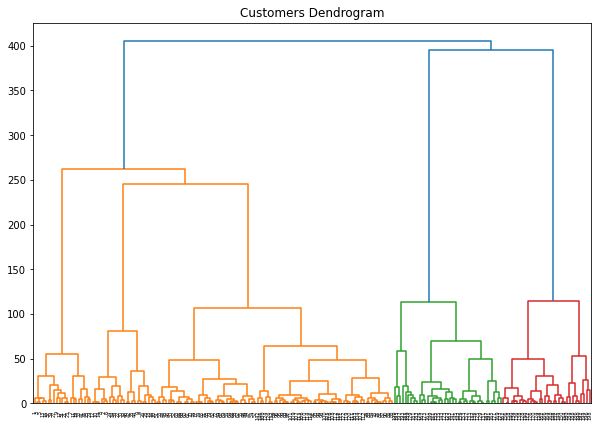

In [12]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Customers Dendrogram")

# Selecting Annual Income and Spending Scores by index
selected_data = customer_data_oh.iloc[:, 2:4]

# todo: calculate the dendrogram using the selected data, 
# and the ward method (let the metric be euclidean), and plot it
# 3 lines

clusters = shc.linkage(selected_data,
            method='ward',
            metric="euclidean")
shc.dendrogram(Z=clusters)

plt.show()

### Linkage Methods
There are many other linkage methods, by understanding more about how they work, you will be able to choose the appropriate one for your needs. Besides that, each of them will yield different results when applied. There is not a fixed rule in clustering analysis, if possible, study the nature of the problem to see which fits its best, test different methods, and inspect the results.

What linkage methods do you know?


Some of the linkage methods are: 

- Single linkage: also referred to as Nearest Neighbor (NN).
- Complete linkage: also referred to as Farthest Neighbor (FN).
- Average linkage: also referred to as UPGMA (Unweighted Pair Group Method with Arithmetic Mean).
- Centroid linkage: also referred to as WPGMA (Weighted Pair Group Method with Arithmetic Mean).
- Ward's linkage: also referred to as WPGMC (Weighted Pair Group Method with Centroid).


#### Distance Metrics

Besides the linkage, we can also specify some of the most used distance metrics 

What distance metrics do you know?

(Euclidean, Manhattan etc.)

We have chosen Ward and Euclidean for the dendrogram because they are the most commonly used method and metric. They usually give good results since Ward links points based on minimizing the errors, and Euclidean works well in lower dimensions.

In this example, we are working with two features (columns) of the marketing data, and 200 observations or rows. Since the number of observations is larger than the number of features (200 > 2), we are working in a low-dimensional space.

If we were to include more attributes, so we have more than 200 features, the Euclidean distance might not work very well, since it would have difficulty in measuring all the small distances in a very large space that only gets larger. In other words, the Euclidean distance approach has difficulties working with the data sparsity. This is an issue that is called the curse of dimensionality. The distance values would get so small, as if they became "diluted" in the larger space, distorted until they became 0.

Finding an interesting number of clusters in a dendrogram is the same as finding the largest horizontal space that doesn't have any vertical lines (the space with the longest vertical lines). This means that there's more separation between the clusters.

We can draw a horizontal line that passes through that longest distance:

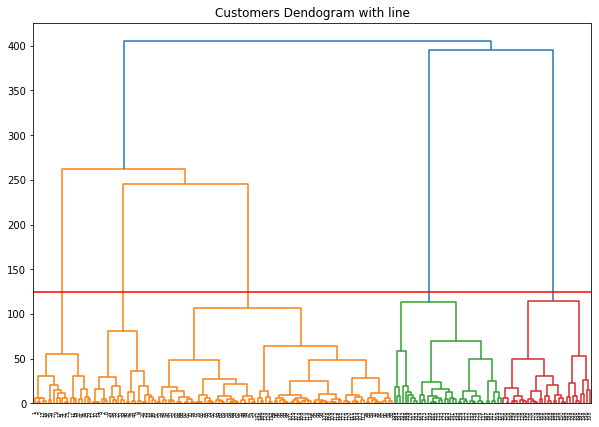

In [13]:
plt.figure(figsize=(10, 7))
plt.title("Customers Dendogram with line")

# todo: calculate the dendrogram using the selected data,
# and the ward method (let the metric be euclidean), and plot it
# also add the horizontal line (let the y be 125) to the plot that cuts the dendrogram
# 3 lines

clusters = shc.linkage(selected_data,
            method='ward',
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 125, color = 'r', linestyle = '-')

How many clusters do we have?

After locating the horizontal line, we count how many times our vertical lines were crossed by it - in this example, 5 times. So 5 seems a good indication of the number of clusters that have the most distance between them.

## Implementing an Agglomerative Hierarchical Clustering
### Using Original Data
So far we've calculated the suggested number of clusters for our dataset that corroborate with our initial analysis. Now we can create our agglomerative hierarchical clustering model using Scikit-Learn AgglomerativeClustering and find out the labels of marketing points with labels_:

In [14]:
from sklearn.cluster import AgglomerativeClustering

# implement the AgglomerativeClustering class with the following parameters:
# n_clusters=5, affinity='euclidean', linkage='ward'
# then fit the selected data
# 2 lines of code
clustering_model = AgglomerativeClustering(n_clusters=5, 
                                           affinity='euclidean', 
                                           linkage='ward')
clustering_model.fit(selected_data)
clustering_model.labels_

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2,
       1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2])

We have investigated a lot to get to this point. And what does these labels mean? Here, we have each point of our data labeled as a group from 0 to 4:

Text(0.5, 1.0, 'Labeled Customer Data')

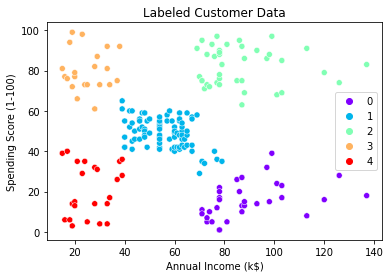

In [18]:
data_labels = clustering_model.labels_

# plot the scatter plot of the selected data, and color it by the data_labels
# 1 line
sns.scatterplot(x='Annual Income (k$)',
                y='Spending Score (1-100)',
                data=selected_data,
                hue=data_labels,
                palette="rainbow").set_title('Labeled Customer Data')

Let's also apply the HCA on the dataset that Kmeans was performing poorly. We will load the data again:

In [18]:
import time
import warnings

import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import numpy as np

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)


<Figure size 986.4x1044 with 0 Axes>

Now let's see how different linkage methods affect the result.

/var/folders/5z/dnc6bnmj0yg8w4883wxckql40000gn/T/ipykernel_99952/2549426494.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = algorithm.labels_.astype(np.int)
/var/folders/5z/dnc6bnmj0yg8w4883wxckql40000gn/T/ipykernel_99952/2549426494.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

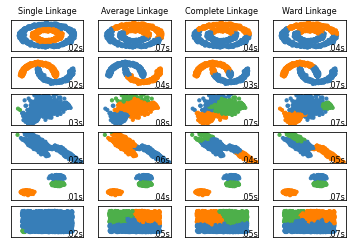

In [29]:
plot_num = 1

default_base = {'n_clusters': 3}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {}),
    (aniso, {}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    # todo: create the AgglomerativeClustering object with the parameters:
    # n_clusters=params['n_clusters'], linkage - based on the name of the variable
    
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    complete = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete')
    average = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average')
    single = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=8)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=8,
                 horizontalalignment='right')
        plot_num += 1

plt.show()


### DBSCAN

What's the pros and cons of DBSCAN?

Pros:

- Does not require to specify number of clusters beforehand.
- Performs well with arbitrary shapes clusters.
- DBSCAN is robust to outliers and able to detect the outliers.

Cons:

- In some cases, determining an appropriate distance of neighborhood (eps) is not easy and it requires domain knowledge.
- If clusters are very different in terms of in-cluster densities, DBSCAN is not well suited to define clusters. The characteristics of clusters are defined by the combination of eps-minPts parameters. Since we pass in one eps-minPts combination to the algorithm, it cannot generalize well to clusters with much different densities.


/var/folders/5z/dnc6bnmj0yg8w4883wxckql40000gn/T/ipykernel_2381/3365863790.py:77: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = algorithm.labels_.astype(np.int)
/var/folders/5z/dnc6bnmj0yg8w4883wxckql40000gn/T/ipykernel_2381/3365863790.py:77: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your

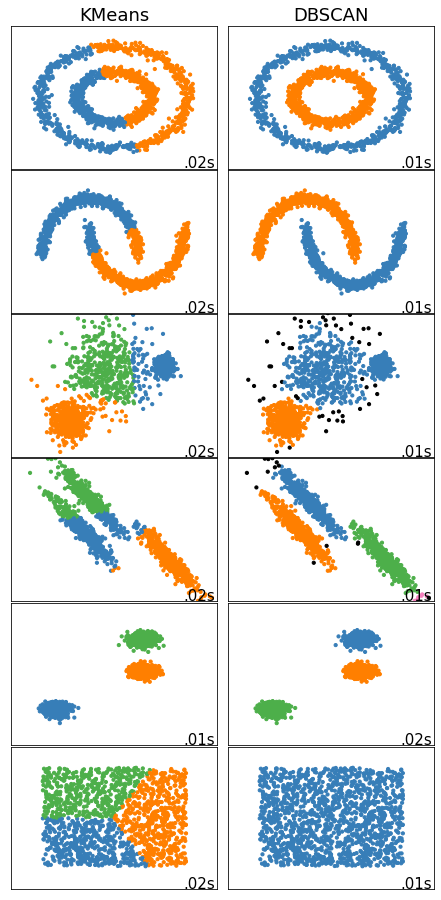

In [20]:
from sklearn.neighbors import kneighbors_graph

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,

                'n_neighbors': 10,
                'n_clusters': 3,
                }

datasets = [
    (noisy_circles, {'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.KMeans(n_clusters=params['n_clusters'])
    dbscan = cluster.DBSCAN(eps=params['eps'])

    clustering_algorithms = (
        ('KMeans', ms),
        ('DBSCAN', dbscan),

    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        #catch warnings related to kneighbors_graph
        # todo: train the appropriate model on the data
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        
        # todo: perform the prediction using the trained model
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right'
                )
        plot_num += 1

plt.subplots_adjust(right=0.3)
plt.show()

Sources:
- https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
- https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556
